# Variational Autoencoder, MNIST

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Set Params

In [4]:
BATCH_SIZE = 64 # number of data points in each batch
N_EPOCHS = 20 # times to run the model on complete data
INPUT_DIM = 28*28 # size of each input
HIDDEN_DIM = 256 # hidden dimension
LATENT_DIM = 20 # latent vector dimension
LR = 1e-3 # learning rate

## Configure Data Loader

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

In [6]:
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Build Variational Autoencoder Architecture

<img src='images/vautoencoder-architecture.png' width='50%'/>

In [8]:
class Encoder(nn.Module):
    ''' This is the encoder part of VAE. '''
    
    def __init__(self, input_dim, hidden_dim, z_dim):
        '''
        Args:
            input_dim: An integer indicating the size of input (in case of MNIST 28*28).
            hidden_dim: An integer indicating the size of hidden dimension.
            z_dim: An integer indicating the latent dimension.
        '''
        
        super(Encoder, self).__init__()
        
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.var = nn.Linear(hidden_dim, z_dim)
        
    def forward(self, x):
        
        hidden = F.relu(self.linear(x))
        z_mu = self.mu(hidden)
        z_var = self.var(hidden)
        
        # outputing μ (a vector of means) 
        # and σ (a vector of standard deviations) of the latent parameters of distribution
        return z_mu, z_var

In [9]:
class Decoder(nn.Module):
    ''' This is the decoder part of VAE. '''
    
    def __init__(self, z_dim, hidden_dim, output_dim):
        '''
        Args:
            z_dim: An integer indicating the latent size.
            hidden_dim: An integer indicating the size of hidden dimension.
            output_dim: An integer indicating the output dimension (in case of MNIST it is 28*28).
        '''
        super(Decoder, self).__init__()
        
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.output = nn.Sequential(
                            nn.Linear(hidden_dim, output_dim),
                            nn.Sigmoid())
        
    def forward(self, x):
        
        hidden = F.relu(self.linear(x))
        x = self.output(hidden)
        
        # outputing reconstructed X 
        return x

In [10]:
class VAE(nn.Module):
    ''' This is the VAE, which takes an encoder and decoder. '''
    
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        
        # -------------
        # Encoder
        # -------------
        z_mu, z_var = self.encoder(x)
        
        # sampling from the distribution having latent parameters z_mu and z_var
        # this will helps decoder to do random sampling
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std) # stochastically generating encoding vectors
        x_sample = eps.mul(std).add_(z_mu)
        
        # -------------
        # Decoder
        # -------------
        x_sample = self.decoder(x_sample)
        
        return x_sample, z_mu, z_var

<img src='images/vautoencoder-distribution.png' width='75%'/>

#### Initialize Autoencoder

In [11]:
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM)
decoder = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM)
vae = VAE(encoder, decoder).to(device)

## Define Loss Function

In [12]:
# this loss will maintains the similarity of nearby encodings on the local scale via clustering
def reconstruction_loss(x_sample, x, reduction='sum'):
    return F.binary_cross_entropy(x_sample, x, reduction=reduction)

In [13]:
# this loss will helps decoder performs smooth interpolation
# by optimizing the probability distribution parameters of μ and σ to closely resemble that of the target distribution
def kl_divergence_loss(z_mu, z_var):
    return 0.5 * torch.sum(torch.exp(z_var) + z_mu**2 - z_var - 1.0)

## Set Optimizer

In [14]:
optimizer = optim.Adam(vae.parameters(), lr=LR)

## Train The Network

In [15]:
best_loss = float('inf')
train_loss_to_display = []
test_loss_to_display = []

for epoch in range (N_EPOCHS):
        
    vae.train()
    train_loss = 0
    for i, (images, _) in enumerate(train_loader):
        x = images.view(-1, 28*28)
        x = x.to(device)
        
        optimizer.zero_grad()
        
        x_sample, z_mu, z_var = vae(x)
        
        r_loss = reconstruction_loss(x_sample, x, reduction='sum')
        kld_loss = kl_divergence_loss(z_mu, z_var)
        loss = r_loss + kld_loss
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (images, _) in enumerate(test_loader):
            x = images.view(-1, 28*28)
            x = x.to(device)

            x_sample, z_mu, z_var = vae(x)

            r_loss = reconstruction_loss(x_sample, x, reduction='sum')
            kld_loss = kl_divergence_loss(z_mu, z_var)
            loss = r_loss + kld_loss
            test_loss += loss.item()
                
    train_loss /= len(train_dataset)
    train_loss_to_display.append(train_loss)
    test_loss /= len(test_dataset)
    test_loss_to_display.append(test_loss)
    
    print('epoch [{}/{}], Train loss: {:.4f}, Test loss: {:.4f}'.format(epoch+1, N_EPOCHS, train_loss, test_loss))
    
    if test_loss < best_loss:
        best_loss = test_loss
        if not os.path.exists('./weights/'): os.makedirs('./weights/')
        torch.save({'state_dict': vae.state_dict()}, './weights/vautoencoder_mnist.pth')

epoch [1/20], Train loss: 155.2653, Test loss: 124.0270
epoch [2/20], Train loss: 119.2124, Test loss: 114.2376
epoch [3/20], Train loss: 113.4419, Test loss: 111.1475
epoch [4/20], Train loss: 111.0224, Test loss: 109.5105
epoch [5/20], Train loss: 109.6629, Test loss: 108.7665
epoch [6/20], Train loss: 108.7591, Test loss: 107.7119
epoch [7/20], Train loss: 108.0728, Test loss: 107.1685
epoch [8/20], Train loss: 107.5522, Test loss: 106.6975
epoch [9/20], Train loss: 107.1371, Test loss: 106.6191
epoch [10/20], Train loss: 106.7759, Test loss: 106.1028
epoch [11/20], Train loss: 106.4379, Test loss: 106.0788
epoch [12/20], Train loss: 106.2064, Test loss: 106.1385
epoch [13/20], Train loss: 106.0233, Test loss: 105.5491
epoch [14/20], Train loss: 105.7559, Test loss: 105.2825
epoch [15/20], Train loss: 105.5862, Test loss: 105.6025
epoch [16/20], Train loss: 105.4434, Test loss: 104.7947
epoch [17/20], Train loss: 105.2751, Test loss: 104.9505
epoch [18/20], Train loss: 105.0974, Tes

## Evaluate The Network

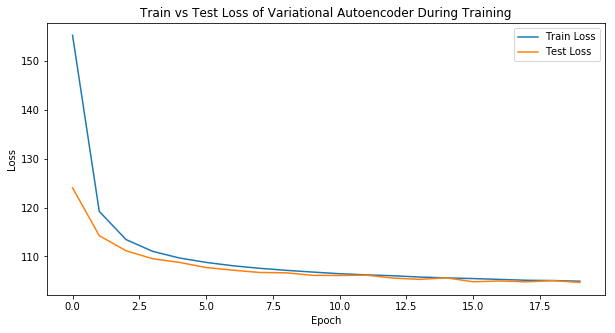

In [16]:
plt.figure(figsize=(10,5))
plt.title("Train vs Test Loss of Variational Autoencoder During Training")
plt.plot(train_loss_to_display, label="Train Loss")
plt.plot(test_loss_to_display, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

if not os.path.exists('./images/vautoencoder'): os.makedirs('./images/vautoencoder')
plt.savefig('./images/vautoencoder/final_loss.png')
plt.show()

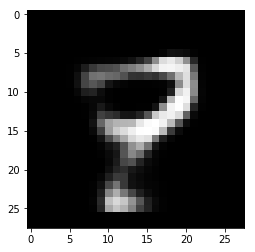

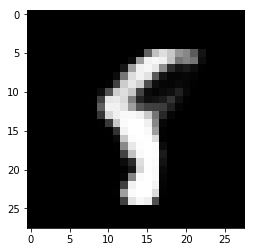

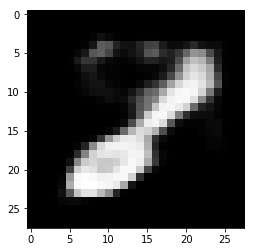

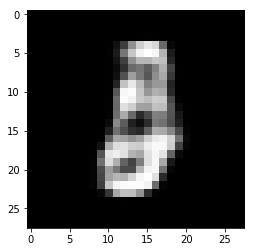

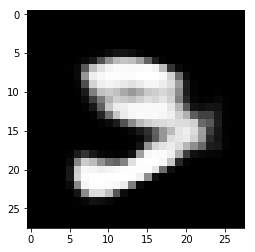

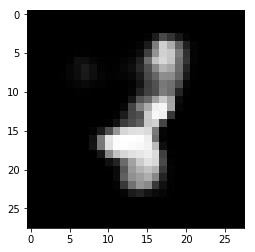

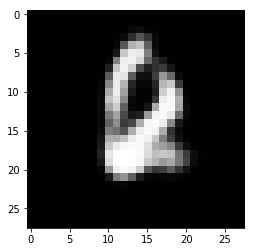

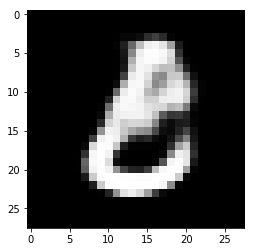

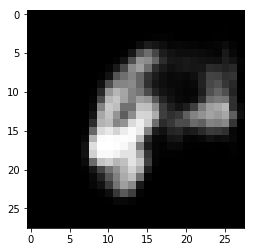

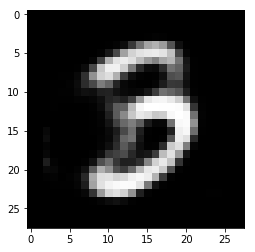

In [17]:
for i in range(10):

    # sample and generate an image
    z = torch.randn(1, LATENT_DIM).to(device)

    result = vae.decoder(z)
    result = result.view(28, 28).data

    plt.imshow(result, cmap='gray')

    plt.savefig('./images/vautoencoder/generated_mnist{}.png'.format(i+1))
    plt.show()

---